In [1]:
from pathlib import Path
import json, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# === Rutas ===
ROOT   = Path.home() / "portafolio-rubin"
PARQUET= ROOT/"data/47tuc_dp1/rnA_matched_minimal.parquet"
JSONP  = ROOT/"data/47tuc_dp1/rnA_metrics.json"

# Flags de exportación
EXPORT_FIG = True
EXPORT_CSV = True

def backup_file(p: Path):
    if p.exists():
        ts = time.strftime("%Y%m%d-%H%M%S")
        bak = p.with_suffix(p.suffix + f".bak-{ts}")
        bak.write_bytes(p.read_bytes())
        print(f"[backup] {p} -> {bak}")

def try_load_json(p: Path):
    if not p.exists():
        print(f"[json] no existe: {p}")
        return None
    try:
        return json.loads(p.read_text())
    except Exception as e:
        print(f"[json] no se pudo parsear como JSON (se reconstruirá): {e}")
        return None

def write_json(p: Path, data: dict):
    p.parent.mkdir(parents=True, exist_ok=True)
    p.write_text(json.dumps(data, indent=2))
    print(f"[json] escrito -> {p}")

print(PARQUET.exists(), JSONP.exists(), PARQUET, JSONP)


True True /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_matched_minimal.parquet /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_metrics.json


In [2]:
df = pd.read_parquet(PARQUET)
display(df.head())

# Δ por coordenada (arcsec). OJO: Δα⋆ = Δα * cos(δ̄)
dec_mid = 0.5*(df["coord_dec"].to_numpy() + df["dec_gaia"].to_numpy())
dra  = (df["coord_ra"].to_numpy()  - df["ra_gaia"].to_numpy())  * np.cos(np.deg2rad(dec_mid)) * 3600.0
ddec = (df["coord_dec"].to_numpy() - df["dec_gaia"].to_numpy()) * 3600.0
r    = np.hypot(dra, ddec)

N = len(df)
p50, p68, p95 = np.percentile(r, [50,68,95])
print(f"N={N}  P50={p50:.6f}\"  P68={p68:.6f}\"  P95={p95:.6f}\"")

print(f"max(r)={r.max():.3f}\"  q99={np.quantile(r,0.99):.3f}\"  q95={np.quantile(r,0.95):.3f}\"")


,objectId,coord_ra,coord_dec,source_id,ra_gaia,dec_gaia,separation_arcsec
534,579578142646088111,5.075909,-71.855793,4689825045638616960,5.075907,-71.855792,0.000000
889,579578692401895176,5.742830,-71.701867,4689849853371562752,5.742831,-71.701865,0.005324
462,579577455451312256,4.844347,-72.044410,4689809137079932544,4.844343,-72.044410,0.005324
455,579578761121371709,5.673968,-71.731994,4689849754585727744,5.673963,-71.731994,0.006147
162,579578142646084079,5.069619,-71.928691,4689812092017502208,5.069616,-71.928690,0.006147


N=1113  P50=0.051023"  P68=0.053354"  P95=0.115831"
max(r)=1.914"  q99=1.173"  q95=0.116"


In [3]:
m2_total = float(np.mean(r**2))
m2_sum   = float(np.mean(dra**2) + np.mean(ddec**2))
diff     = abs(m2_total - m2_sum)

thr = float(np.quantile(r, 0.95))
core = r <= thr
m2_core = float(np.mean(r[core]**2))
m2_tail = float(np.mean(r[~core]**2))
mix = 0.95*m2_core + 0.05*m2_tail

print("[sanity] mean(r^2) =", m2_total)
print("[sanity] mean(dx^2)+mean(dy^2) =", m2_sum)
print("[sanity] abs diff =", diff)
print("[tails] q95 =", thr, "  E[r^2]_core =", m2_core, "  E[r^2]_tail =", m2_tail, "  mix =", mix)

# Resumen adicional (no imprescindible)
tail_stats = pd.Series(r[~core]).describe(percentiles=[0.5,0.75,0.9,0.95,0.99])
display(tail_stats.to_frame("tail_r_arcsec"))


[sanity] mean(r^2) = 0.03872855313494303
[sanity] mean(dx^2)+mean(dy^2) = 0.03872855313494302
[sanity] abs diff = 6.938893903907228e-18
[tails] q95 = 0.11583075491800637   E[r^2]_core = 0.002439143206214213   E[r^2]_tail = 0.7236911655396993   mix = 0.03850174432288846


,tail_r_arcsec
count,56.000000
mean,0.613575
std,0.594584
min,0.117051
50%,0.265203
75%,0.891112
90%,1.706432
95%,1.794313
99%,1.899164
max,1.914006


In [4]:
# RMS clásico (arcsec y mas)
rms_ra  = float(np.sqrt(np.mean(dra**2)))
rms_dec = float(np.sqrt(np.mean(ddec**2)))

# Robustez por recorte 1% en r (filtrado, no winsorización estricta)
q01, q99 = np.quantile(r, [0.01, 0.99])
m = (r>=q01)&(r<=q99)
rms_ra_rob  = float(np.sqrt(np.mean(dra[m]**2)))
rms_dec_rob = float(np.sqrt(np.mean(ddec[m]**2)))

print("[RMS] per-axis (arcsec):", rms_ra, rms_dec)
print("[RMS] per-axis (mas):", 1000*np.array([rms_ra, rms_dec]))
print("[RMS robust 1%] (arcsec):", rms_ra_rob, rms_dec_rob)
print("[RMS robust 1%] (mas):", 1000*np.array([rms_ra_rob, rms_dec_rob]))


[RMS] per-axis (arcsec): 0.13090993556974592 0.14693924562235916
[RMS] per-axis (mas): [130.90993557 146.93924562]
[RMS robust 1%] (arcsec): 0.07826910562756059 0.05856631518899164
[RMS robust 1%] (mas): [78.26910563 58.56631519]


,quantile,rms_ra_mas,rms_dec_mas
0,0.50,33.221083,20.351363
1,0.52,33.743773,20.517256
2,0.54,34.245625,20.654053
3,0.56,34.731964,20.762859
4,0.58,35.206640,20.839395


[export] CSV -> /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_influence_curve.csv
[export] FIG -> /home/marcelor/portafolio-rubin/notebooks/47tuc/figs/rnA_influence_curve.png


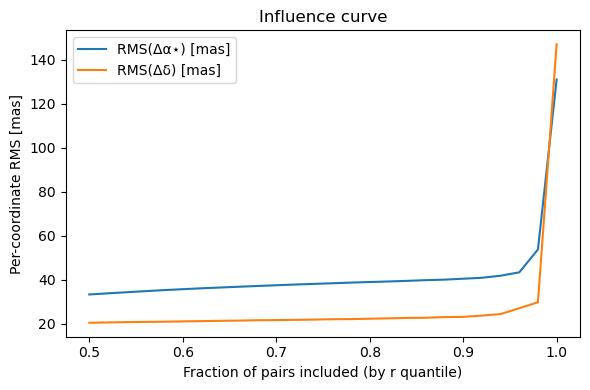

In [5]:
qs = np.linspace(0.50, 1.00, 26)
rms_ra_q, rms_dec_q = [], []
for q in qs:
    t = np.quantile(r, q)
    kk = r <= t
    rms_ra_q.append(float(np.sqrt(np.mean(dra[kk]**2))))
    rms_dec_q.append(float(np.sqrt(np.mean(ddec[kk]**2))))

inf_df = pd.DataFrame({
    "quantile": qs,
    "rms_ra_mas": np.array(rms_ra_q)*1000.0,
    "rms_dec_mas": np.array(rms_dec_q)*1000.0
})
display(inf_df.head())

if EXPORT_CSV:
    outcsv = ROOT/"data/47tuc_dp1/rnA_influence_curve.csv"
    inf_df.to_csv(outcsv, index=False)
    print("[export] CSV ->", outcsv)

if EXPORT_FIG:
    outfig = ROOT/"notebooks/47tuc/figs/rnA_influence_curve.png"
    outfig.parent.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(6,4))
    plt.plot(inf_df["quantile"], inf_df["rms_ra_mas"], label="RMS(Δα⋆) [mas]")
    plt.plot(inf_df["quantile"], inf_df["rms_dec_mas"], label="RMS(Δδ) [mas]")
    plt.xlabel("Fraction of pairs included (by r quantile)")
    plt.ylabel("Per-coordinate RMS [mas]")
    plt.title("Influence curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfig, dpi=150)
    print("[export] FIG ->", outfig)


In [6]:
# 1) Carga (o reconstruye) el JSON
backup_file(JSONP)
data = try_load_json(JSONP)

if data is None:
    # Reconstrucción mínima desde el parquet (y respetando claves “planas”)
    data = {
        "N_pairs": int(N),
        "P50_arcsec": float(p50),
        "P68_arcsec": float(p68),
        "P95_arcsec": float(p95),
    }
    print("[json] reconstruido mínimamente desde parquet.")

# 2) Añadir/actualizar campos ya existentes para mantener consistencia
data["N_pairs"]     = int(N)
data["P50_arcsec"]  = float(p50)
data["P68_arcsec"]  = float(p68)
data["P95_arcsec"]  = float(p95)

# 3) Nuevos bloques: robustos y r^2
data["per_coordinate_robust01_mas"] = {
    "rms_ra":  1000.0*rms_ra_rob,
    "rms_dec": 1000.0*rms_dec_rob
}
data["tails_summary"] = {
    "quantile_split": 0.95,
    "r2_core_arcsec2": m2_core,
    "r2_tail_arcsec2": m2_tail,
    "r2_mix_arcsec2": mix,
    "sanity_mean_r2": m2_total,
    "sanity_mean_dx2_plus_dy2": m2_sum,
    "sanity_absdiff": diff
}

# 4) Metadatos del generador
gen = data.get("generator", {})
gen["rna_r2_sanity_notebook"] = {
    "notebook": "notebooks/47tuc/rnA_r2_sanity_and_influence.ipynb",
    "version": "v1.0"
}
data["generator"] = gen

# 5) Escribir
write_json(JSONP, data)

# Vista previa
print(json.dumps(data, indent=2)[:1200])


[backup] /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_metrics.json -> /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_metrics.json.bak-20250909-060413
[json] escrito -> /home/marcelor/portafolio-rubin/data/47tuc_dp1/rnA_metrics.json
{
  "N_pairs": 1113,
  "P50_arcsec": 0.051022827161944,
  "P68_arcsec": 0.053353692802722556,
  "P95_arcsec": 0.11583075491800637,
  "P50_ci95_arcsec": [
    0.050690864503642435,
    0.051430916269940744
  ],
  "P95_ci95_arcsec": [
    0.09780514929323501,
    0.17069029791484716
  ],
  "bootstrap_B": 5000,
  "bootstrap_seed": 47,
  "method_note": "1:1 dentro de 2\u2033; percentiles sobre separaciones; IC-95% por bootstrap.",
  "units": "arcsec",
  "generator": {
    "script": "notebooks/47tuc/rnA_per_coordinate_metrics.ipynb",
    "version": "v1.1-rnA",
    "rna_r2_sanity_notebook": {
      "notebook": "notebooks/47tuc/rnA_r2_sanity_and_influence.ipynb",
      "version": "v1.0"
    }
  },
  "P68_ci95_arcsec": [
    0.05296920692603931,
    0.0537